# Group WNT - KDE

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.preprocessing import StandardScaler

import scipy as sp
#from scipy.signal import fftconvolve

import numba 

from concurrent.futures import ProcessPoolExecutor, as_completed

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
path_data = '/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/data/in/protein_coding/'
path_metadata = path_data + 'GSE85217_Cavalli_subgroups_information_protein_coding.csv'
path_expr_mat = path_data + 'GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab_protein_coding.csv'

In [3]:
metadata = pd.read_csv(path_metadata,index_col=0)
expr_mat = pd.read_csv(path_expr_mat,index_col=0)

In [4]:
# order using mean, median and std
expr_mat_order_vars = pd.concat([expr_mat.mean(axis=0),expr_mat.median(axis=0),expr_mat.std(axis=0)],axis=1)
expr_mat_order_vars.columns = ['mean','median','sd']
expr_mat_order_vars.sort_values(by=['mean','median','sd'],inplace=True)

expr_mat=expr_mat[expr_mat_order_vars.index.tolist()]

In [5]:
# select WNT samples
expr_mat_wnt = expr_mat.loc[metadata[metadata['Subgroup']=='WNT']['Study_ID'].to_list(),:]

In [6]:
# standardize the data 
sc = StandardScaler()
expr_mat_wnt_sc = sc.fit_transform(expr_mat_wnt)

In [7]:
def fast_kde(x,y, gridsize=(300,300), epsilon=1e-10, extents=None, nocorrelation=True, weights=None, cov=None):

    # SETUP
    x = np.squeeze((np.asarray(x)))
    y = np.squeeze((np.asarray(y)))

    if x.size != y.size:
        raise ValueError('Input x & y arrays must be the same size!')

    n = x.size

    if weights is None:
        # Default: Weight all points equally
        weights = np.ones(n)
    else:
        weights = np.squeeze(np.asarray(weights))
        if weights.size != x.size:
            raise ValueError('Input weights must be an array of the same size'
                    ' as input x & y arrays!')

    if extents is None:
        xmin=x.min()
        xmax=x.max()
        ymin=y.min()
        ymax=y.max()
    else :
        xmin, xmax, ymin, ymax = map(float, extents)

    dx = (xmax - xmin) / (gridsize[0] - 1)
    dy = (ymax - ymin) / (gridsize[1] - 1)

    # PRELIMINARY CALCULATIONS

    # First convert x & y over to pixel coordinates
    # (Avoiding np.digitize due to excessive memory usage!)
    
    # Adjust x and y to pixel coordinates inplace
    x_pixel = np.floor((x - xmin) / dx)
    y_pixel = np.floor((y - ymin) / dy)

    # Stack the results after adjustment
    xyi = np.vstack((x_pixel, y_pixel))

    # Next, make a 2D histogram of x & y
    # Avoiding np.histogram2d due to excessive memory usage with many points
    grid = sp.sparse.coo_matrix((weights, xyi), shape=(gridsize)).toarray()

    if cov is None:
        cov = np.cov(xyi)

    if nocorrelation:
        cov[1, 0] = 0
        cov[0, 1] = 0

    # Scaling factor for bandwidth
    scotts_factor = np.power(n, -1.0 / 6) # For 2D

    # MAKE THE GAUSSIAN KERNEL

    # First, determine how big the kernel needs to be
    std_devs = np.diag(np.sqrt(cov))
    kern_nx, kern_ny = np.round(scotts_factor * 2 * np.pi * std_devs)
 
    # Determine the bandwidth to use for the gaussian kernel
    inv_cov = np.linalg.inv(cov * scotts_factor**2) 
 
    # x & y (pixel) coords of the kernel grid, with <x,y> = <0,0> in center
    xx = np.arange(kern_nx) - kern_nx / 2.0
    yy = np.arange(kern_ny) - kern_ny / 2.0
    xx, yy = np.meshgrid(xx, yy)
 
    # Then evaluate the gaussian function on the kernel grid
    kernel = np.vstack((xx.flatten(), yy.flatten()))
    kernel = np.dot(inv_cov, kernel) * kernel
    kernel = np.sum(kernel, axis=0) / 2.0
    kernel = np.exp(-kernel).reshape(np.int64(kern_ny), np.int64(kern_nx))

    # THE KERNEL DENSITY ESTIMATE

    # Convolve the gaussian kernel with the 2D histogram, producing a gaussian
    # kernel density estimate on a regular grid
    #grid = sp.signal.convolve2d(grid, kernel, mode='same', boundary='fill').T
    grid = sp.signal.fftconvolve(grid, kernel, mode='same').T
    
    # Normalization factor to divide result by so that units are in the same
    # units as scipy.stats.kde.gaussian_kde's output.  
    #norm_factor = 2 * np.pi * cov * scotts_factor**2
    #norm_factor = np.linalg.det(norm_factor)
    #norm_factor = n * dx * dy * np.sqrt(norm_factor)
    det = np.linalg.det(cov)
    if det < 0 :
        sqrt_det = -np.sqrt(det)
    else :
        sqrt_det = np.sqrt(det)
    
    norm_factor = n * dx * dy * (2 * np.pi) * scotts_factor**2 * sqrt_det

 
    # Normalize the result
    grid /= norm_factor

    grid+=grid.min()

    return grid,xyi #np.flipud(grid)

    



In [8]:
toys_data_gene_1 = expr_mat_wnt_sc[:,4]
toys_data_gene_2 = expr_mat_wnt_sc[:,0]

In [9]:
%%time
kde ,xyi =fast_kde(x=toys_data_gene_1,y=toys_data_gene_2)

CPU times: user 36.3 ms, sys: 15 ms, total: 51.3 ms
Wall time: 26.3 ms


In [10]:
l_kde = [kde[i,j] for i,j in zip(*np.where(kde < 1))]
np.mean(l_kde)
max(l_kde)

0.1766610704418423

In [11]:
def epsilon_marge_to_null(kde, epsilon=1e-10):

    np.where((kde > -epsilon) | (kde < epsilon),epsilon,kde)
    pass

In [12]:
kde[0,174]

0.0692487003661484

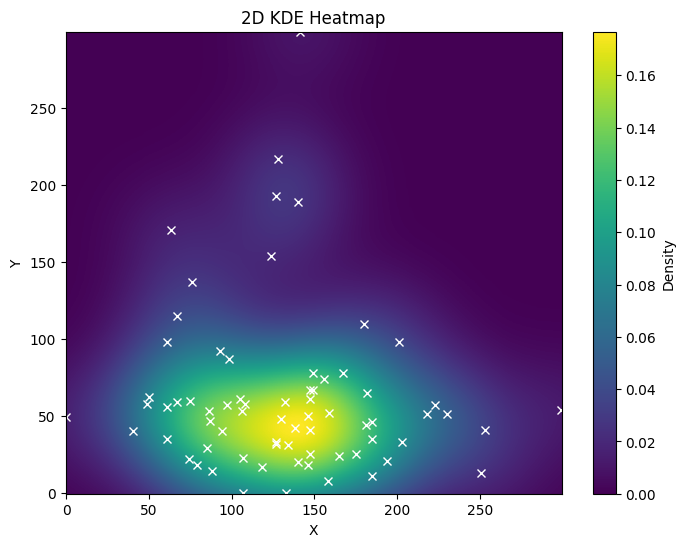

In [13]:
plt.figure(figsize=(8, 6))
plt.imshow(kde, origin='lower', cmap='viridis', aspect='auto')
plt.plot(xyi[0,:],xyi[1,:],'x',c="white")
plt.colorbar(label='Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D KDE Heatmap')
plt.show()

In [14]:
@numba.jit(nopython=True)
def shannon_mi_from_kde(kde,epsilon=1e-10,scale = True, normalize=True):

    if scale :
        kde /= np.sum(kde)

    p_xy = np.where(kde < epsilon, epsilon, kde)

    p_x = np.sum(p_xy, axis=0)
    p_y = np.sum(p_xy, axis=1)

    mi = np.sum(p_xy * np.log2(p_xy / (p_x * p_y)))

    h_x = -np.sum(p_x * np.log2(p_x))
    h_y = -np.sum(p_y * np.log2(p_y))

    if normalize:
        mi /= np.sqrt(h_x * h_y)
    
    return mi

In [15]:
%%timeit -n 10
nmi = shannon_mi_from_kde(kde)
nmi

The slowest run took 233.76 times longer than the fastest. This could mean that an intermediate result is being cached.
60.4 ms ± 143 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
def scale_xy_to_grid(x:np.ndarray,y:np.ndarray,gridsize=(200,200),extents=None):

    if extents is None:
        xmin = x.min(axis=0)
        xmax = x.max(axis=0)
        ymin = y.min(axis=0)
        ymax = y.max(axis=0)
    else : 
        xmin, xmax, ymin, ymax = map(np.ndarray, extents)

    dx = (xmax - xmin) / (gridsize[0] - 1)
    dy = (ymax - ymin) / (gridsize[1] - 1)

    xmin = xmin.reshape(1,-1)
    ymin = ymin.reshape(1,-1)

    dx = dx.reshape(1,-1)
    dy = dy.reshape(1,-1)

    # Adjust x and y to pixel coordinates inplace
    x_pix = np.floor((x - xmin) / dx)
    y_pix = np.floor((y - ymin) / dy)
    
    return x_pix, y_pix, list(dx[0,:]), list(dx[0,:])

In [17]:
#%timeit -n 100 scale_xy_to_grid(x=expr_mat_wnt_sc[:,0:100],y=expr_mat_wnt_sc[:,0:100])

In [18]:
def cov_vars(x,y,nocorr=True):

    x = np.asarray(x).T[:, np.newaxis, :]
    y = np.asarray(y).T
    n = x.shape[-1]



    xm = x.mean(axis=-1, keepdims=True)
    ym = y.mean(axis=-1, keepdims=True)

    cov = np.sum((x - xm) * (y - ym), axis=-1)/(n-1)

    std_x = np.std(x, ddof=1, axis=-1)
    std_y = np.std(y, ddof=1, axis=-1)

    if nocorr:
        np.fill_diagonal(cov,0)
        
    return cov, std_x**2, std_y**2

In [19]:
#cov, vars_x, vars_y = cov_vars(x=expr_mat_wnt_sc[:,0:100],y=expr_mat_wnt_sc[:,0:100])

In [20]:
def set_cov(cov,vars):
    cov = cov[[0,1],:][:,[0,1]]
    cov[0,0]=vars[0]
    cov[1,1]=vars[1]
    return cov

In [21]:
def get_kernel(scotts_factor,stds,inv_cov):

    kern_nx, kern_ny = np.round(scotts_factor * 2 * np.pi * stds)

    # x & y (pixel) coords of the kernel grid, with <x,y> = <0,0> in center
    xx = np.arange(kern_nx) - kern_nx / 2.0
    yy = np.arange(kern_ny) - kern_ny / 2.0
    xx, yy = np.meshgrid(xx, yy)
     
    # Then evaluate the gaussian function on the kernel grid
    kernel = np.vstack((xx.flatten(), yy.flatten()))

    kernel = np.dot(inv_cov, kernel) * kernel
    kernel = np.sum(kernel, axis=0) / 2.0
    kernel = np.exp(-kernel).reshape(np.int64(kern_ny), np.int64(kern_nx))

    return kernel

In [22]:
def batch_mi(x,y,gridsize=(200,200),epsilon=1e-10,k=1):

    x_pix, y_pix, dx, dy = scale_xy_to_grid(x,y)

    n = x.shape[0]
    weights = np.ones(n)

    # Scaling factor for bandwidth
    scotts_factor = np.power(n, -1.0 / 6) # For 2D

    batch_mi_mat = np.zeros((x.shape[-1],y.shape[-1]))

    cov_xy, vars_x, vars_y = cov_vars(x_pix,y_pix,nocorr=True)

    for i,j in zip(*np.triu_indices(x.shape[1], k=k)):

        xyi = np.vstack((x_pix[:,i],y_pix[:,j]))
        grid = sp.sparse.coo_matrix((weights, xyi), shape=(gridsize)).toarray()

        #vars = np.vstack((vars_x[i],vars_y[j]))


        cov = set_cov(cov_xy,(vars_x[i],vars_y[j]))

        stds = std_devs = np.sqrt(np.diag(cov))
        

        # Determine the bandwidth to use for the gaussian kernel
        inv_cov = np.linalg.inv(cov * scotts_factor**2)
            
        kernel = get_kernel(scotts_factor,stds,inv_cov)
    
        grid = sp.signal.fftconvolve(grid, kernel, mode='same').T

        det = np.linalg.det(cov)
        if det < 0 :
            sqrt_det = -np.sqrt(det)
        else :
            sqrt_det = np.sqrt(det)
    
        norm_factor = n * dx[i] * dy[j] * (2 * np.pi) * scotts_factor**2 * sqrt_det

        # Normalize the result
        grid /= norm_factor

        grid+=abs(grid.min())
    
        batch_mi_mat[i,j]=shannon_mi_from_kde(grid,epsilon=1e-10,scale = True, normalize=True)

    if k == 0 :
        batch_mi_mat += batch_mi_mat.T
        
    return batch_mi_mat

In [23]:
#%%timeit -n 2
#batch_mi_mat=batch_mi(x=expr_mat_wnt_sc[:,0:5],y=expr_mat_wnt_sc[:,0:5])
#batch_mi_mat

In [24]:
import threading
import psutil
import time

class ResourceMonitor:
    def __init__(self,t_sleep=1):
        # Event to control when to stop the monitoring thread
        self._stop_event = threading.Event()
        self.monitor_thread = threading.Thread(target=self.monitor_resources, daemon=True)
        self.t_sleep=t_sleep

    def monitor_resources(self):
        while not self._stop_event.is_set():
            print(f"RAM Usage: {psutil.virtual_memory().percent}% | CPU Usage: {psutil.cpu_percent()}%")
            time.sleep(self.t_sleep)

    def start(self):
        # Start the daemon thread
        self.monitor_thread.start()

    def stop(self):
        # Signal the thread to stop and wait for it to finish
        self._stop_event.set()
        self.monitor_thread.join()  # Wait for the thread to terminate cleanly

In [25]:
def chunkify_expr_mat(expr_mat,start=0,step=10):
    
    chunk_points = list(range(start,expr_mat.shape[1],step))+[expr_mat.shape[1]]
    
    for i in range(len(chunk_points)-1):
        yield chunk_points[i],chunk_points[i+1]

In [26]:
def all_chunks(expr_mat,start=0,step=5):
    
    chunks = [chunk for chunk in chunkify_expr_mat(expr_mat=expr_mat,start=start,step=step)]

    for i,j in zip(*np.triu_indices(n=len(chunks))):
        if chunks[i]==chunks[j]:
            k = 1
        else:
            k = 0
   
        yield chunks[i], chunks[j], k


In [41]:
%%time
mi_array=np.zeros((150,150))
for chunk1, chunk2, k in all_chunks(expr_mat=expr_mat_wnt_sc[:,0:150],step=5):
    chunk1_array = expr_mat_wnt_sc[:,chunk1[0]:chunk1[1]]
    chunk1_array = expr_mat_wnt_sc[:,chunk2[0]:chunk2[1]]
    mi_array[chunk1[0]:chunk1[1],chunk2[0]:chunk2[1]]=batch_mi(x=chunk1_array,y=chunk1_array,gridsize=(200,200),epsilon=1e-10,k=k)   

CPU times: user 36.9 s, sys: 15.7 s, total: 52.6 s
Wall time: 26.3 s


In [28]:
mi_array

array([[ 0.        ,  0.2502673 ,  0.02261702, ...,  0.01739637,
         0.00880783,  0.0344787 ],
       [ 0.        ,  0.        ,  0.03040382, ...,  0.02197841,
        -0.00400111,  0.04831146],
       [ 0.        ,  0.        ,  0.        , ...,  0.17113452,
         0.00686185,  0.01915308],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00686185,  0.01915308],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.02949004],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [35]:
def pool_compute_mi_mat(expr_mat,step=5,epsilon=1e-10,gridsize=(200,200),t_spleep=1):

    adj_mat = np.zeros((expr_mat.shape[1],expr_mat.shape[1]))

    monitor = ResourceMonitor(t_spleep)
    monitor.start()

    results_dict={}
    with ProcessPoolExecutor(max_workers=8) as executor:
        futures = {executor.submit(batch_mi,expr_mat[:,chunk1[0]:chunk1[1]],expr_mat[:,chunk2[0]:chunk2[1]],gridsize,epsilon,k):np.array([chunk1,chunk2]) for chunk1, chunk2, k in all_chunks(expr_mat=expr_mat,step=step)}

        for future in as_completed(futures):
            chunks = futures[future]

            try:
                adj_mat[chunks[0][0]:chunks[0][1],chunks[1][0]:chunks[1][1]]=future.result()
            except Exception as e:
                print(f"Error in processing {chunks}: {e}")

    monitor.stop()
    return adj_mat

In [42]:
%%time
adj_mi_mat=pool_compute_mi_mat(expr_mat=expr_mat_wnt_sc[:,0:100],t_spleep=10)

RAM Usage: 55.1% | CPU Usage: 9.3%
CPU times: user 165 ms, sys: 164 ms, total: 329 ms
Wall time: 10 s
